## (a) Basic preprocessing
- Feature selection: keep useful variables and drop pure IDs (`id`, `aoi_id`, `shop_id`).
- Encoding: convert categorical variables (`weather_grade`, `source_type`) into numbers.
- Outlier removal: remove unreasonable `expected_use_time`.
- Downsampling: sample 20,000 rows for faster experiments.
- Quick EDA: summary stats + simple plots to guide modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load data
train_df = pd.read_csv('dataframe_train.csv')
test_df = pd.read_csv('dataframe_test.csv')
print("Shapes:", train_df.shape, test_df.shape)

# Encode classification target
train_df['action_type_encoded'] = train_df['action_type'].map({'DELIVERY': 1, 'PICKUP': 0})

# Encode categorical features (fit on train + test)
cat_features = ['weather_grade', 'source_type']
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], test_df[col]], axis=0).astype(str))
    train_df[col + '_encoded'] = le.transform(train_df[col].astype(str))
    test_df[col + '_encoded'] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

# Remove extreme values for regression target
train_df = train_df[(train_df['expected_use_time'] > 0) & (train_df['expected_use_time'] < 7200)]

# Define base features
base_features = [
    'level', 'speed', 'max_load', 'weather_grade_encoded', 'source_type_encoded',
    'grid_distance', 'urgency', 'hour',
    'source_lng', 'source_lat', 'target_lng', 'target_lat'
]

# Sample a subset for quick experiments
train_sample = train_df.sample(n=20000, random_state=42).copy()
print("Sample shape:", train_sample.shape)

训练集形状: (509604, 25), 测试集形状: (25468, 23)

训练集列名:
['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng', 'courier_wave_start_lat', 'action_type', 'date', 'group', 'level', 'speed', 'max_load', 'weather_grade', 'aoi_id', 'shop_id', 'id', 'source_type', 'source_tracking_id', 'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance', 'expected_use_time', 'urgency', 'hour']

训练集缺失值:
Series([], dtype: int64)

去除离群值前: 509604 行
去除离群值后: 509599 行

已采样20000条数据用于初步探索

--- 统计摘要（采样数据）---
         level     speed  max_load  weather_grade_encoded  \
count  20000.0  20000.00  20000.00               20000.00   
mean       2.6      5.35      8.97                   1.37   
std        0.7      0.62      2.02                   0.70   
min        0.0      3.01      1.00                   0.00   
25%        2.0      4.87      8.00                   1.00   
50%        3.0      5.46      9.00                   1.00   
75%        3.0      5.77     10.00                   1.00   
max  

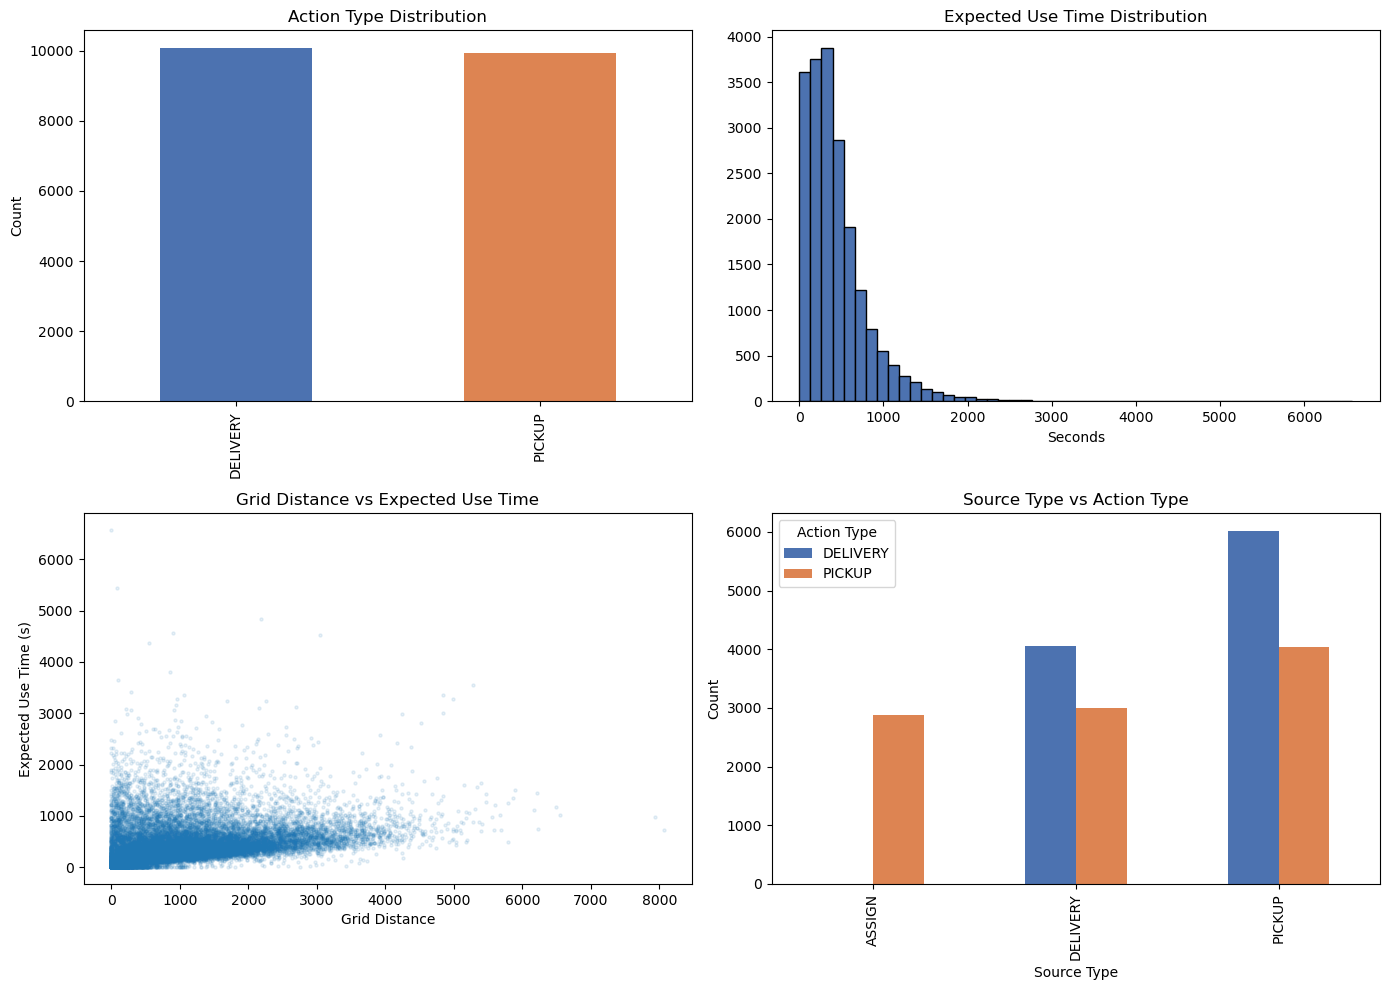

In [4]:
# EDA Visualizations (Simplified: Plan B)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Classification target distribution
train_sample['action_type'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['#4C72B0', '#DD8452'])
axes[0, 0].set_title('Action Type Distribution')
axes[0, 0].set_ylabel('Count')

# 2. Regression target distribution
axes[0, 1].hist(train_sample['expected_use_time'], bins=50, color='#4C72B0', edgecolor='black')
axes[0, 1].set_title('Expected Use Time Distribution')
axes[0, 1].set_xlabel('Seconds')

# 3. Grid distance vs expected_use_time
axes[1, 0].scatter(train_sample['grid_distance'], train_sample['expected_use_time'], alpha=0.1, s=5)
axes[1, 0].set_title('Grid Distance vs Expected Use Time')
axes[1, 0].set_xlabel('Grid Distance')
axes[1, 0].set_ylabel('Expected Use Time (s)')

# 4. Source type vs action type
pd.crosstab(train_sample['source_type'], train_sample['action_type']).plot(
    kind='bar', ax=axes[1, 1], color=['#4C72B0', '#DD8452']
)
axes[1, 1].set_title('Source Type vs Action Type')
axes[1, 1].set_xlabel('Source Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(title='Action Type')

plt.tight_layout()
plt.show()

## (b) Baselines
- Classification: Logistic Regression with 5-fold stratified CV, report F1.
- Regression: Linear Regression with 5-fold CV, report MAE.
- Use the 20,000-row sample from (a).

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler

# Prepare sample data
X_sample = train_sample[base_features].fillna(0)
y_clf_sample = train_sample['action_type_encoded']
y_reg_sample = train_sample['expected_use_time']

# Scale features for linear models
X_sample_scaled = StandardScaler().fit_transform(X_sample)

# Logistic Regression baseline (F1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(
    LogisticRegression(max_iter=1000, random_state=42),
    X_sample_scaled,
    y_clf_sample,
    cv=skf,
    scoring='f1'
)
print("LR F1:", f"{np.mean(f1_scores):.4f}", "+/-", f"{np.std(f1_scores):.4f}")

# Linear Regression baseline (MAE)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = cross_val_score(
    LinearRegression(),
    X_sample_scaled,
    y_reg_sample,
    cv=kf,
    scoring='neg_mean_absolute_error'
)
print("LinReg MAE:", f"{-np.mean(mae_scores):.2f}", "+/-", f"{np.std(mae_scores):.2f}")

        level     speed  max_load  weather_grade_encoded  source_type_encoded  \
28765       3  4.374083        10                      1                    2   
487564      3  5.231869        10                      1                    3   
233335      3  5.858490         9                      3                    2   
6456        3  4.707674        10                      1                    2   
230973      3  6.322123         9                      3                    3   
...       ...       ...       ...                    ...                  ...   
455297      3  5.885442         6                      1                    2   
94546       3  4.544820         9                      3                    2   
321736      3  5.193327         9                      1                    3   
431019      2  5.901096         6                      1                    2   
39581       3  4.678065         7                      1                    3   

        grid_distance  urge

## (c) Stronger models
Try Random Forest and Gradient Boosting with RandomizedSearchCV.
Still use the 20,000-row sample for faster tuning.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Prepare data
X_sample = train_sample[base_features].fillna(0)
y_clf_sample = train_sample['action_type_encoded']
y_reg_sample = train_sample['expected_use_time']

# Random Forest for classification
rs_clf_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions={
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', None]
    },
    n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1
)
rs_clf_rf.fit(X_sample, y_clf_sample)
print("RF (clf) best F1:", f"{rs_clf_rf.best_score_:.4f}")

# Gradient Boosting for classification
rs_clf_gb = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions={
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1
)
rs_clf_gb.fit(X_sample, y_clf_sample)
print("GB (clf) best F1:", f"{rs_clf_gb.best_score_:.4f}")

# Random Forest for regression
rs_reg_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions={
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_leaf': [1, 2, 4]
    },
    n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
)
rs_reg_rf.fit(X_sample, y_reg_sample)
print("RF (reg) best MAE:", f"{-rs_reg_rf.best_score_:.2f}")

# Gradient Boosting for regression
rs_reg_gb = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions={
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    },
    n_iter=10, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
)
rs_reg_gb.fit(X_sample, y_reg_sample)
print("GB (reg) best MAE:", f"{-rs_reg_gb.best_score_:.2f}")

分类 - 随机森林 最佳 F1: 0.8027
  最佳参数: {'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 20, 'class_weight': None}


KeyboardInterrupt: 

## (d) Feature engineering
Add a few simple and interpretable features on top of the base set:
1. Haversine distance between source and target (km).
2. Distance from wave start to current source (km).
3. Time proxy: `time_est = grid_distance / speed`.
4. Peak-hour flags: lunch (11-13) and dinner (17-19).
5. Wave progress features: `action_rank`, `wave_total_actions`, `action_progress`.

In [ ]:
def build_features(df):
    df = df.sort_values(by=['courier_id', 'date', 'wave_index', 'id']).reset_index(drop=True)

    # Haversine distance (km)
    def haversine(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon, dlat = lon2 - lon1, lat2 - lat1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return 2 * np.arcsin(np.sqrt(a)) * 6371

    # Distance features
    df['dist_direct_km'] = haversine(df['source_lng'], df['source_lat'], df['target_lng'], df['target_lat'])
    df['dist_from_wave_start'] = haversine(df['courier_wave_start_lng'], df['courier_wave_start_lat'], df['source_lng'], df['source_lat'])

    # Time proxy
    df['time_est'] = df['grid_distance'] / (df['speed'] + 1e-6)

    # Peak-hour flags
    df['is_lunch_peak'] = ((df['hour'] >= 11) & (df['hour'] <= 13)).astype(int)
    df['is_dinner_peak'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)

    # Wave progress features
    df['action_rank'] = df.groupby(['courier_id', 'date', 'wave_index']).cumcount()
    df['wave_total_actions'] = df.groupby(['courier_id', 'date', 'wave_index'])['id'].transform('count')
    df['action_progress'] = df['action_rank'] / (df['wave_total_actions'] + 1e-6)

    # Ensure encoded columns exist
    if 'source_type_encoded' not in df.columns:
        for col in ['weather_grade', 'source_type']:
            if col in label_encoders:
                df[col + '_encoded'] = label_encoders[col].transform(df[col].astype(str))

    return df


# Build features
train_fe = build_features(train_df)
test_fe = build_features(test_df)

# Final feature list
enhanced_features = [
    'level', 'speed', 'max_load', 'weather_grade_encoded', 'source_type_encoded',
    'grid_distance', 'urgency', 'hour',
    'source_lng', 'source_lat', 'target_lng', 'target_lat',
    'dist_direct_km', 'dist_from_wave_start', 'time_est',
    'is_lunch_peak', 'is_dinner_peak',
    'action_rank', 'wave_total_actions', 'action_progress'
]

print("FE shapes:", train_fe.shape, test_fe.shape)

## (e) Final training + submission + interpretation
- Train final models on the full training set using engineered features.
- Use cross-validation to check whether F1 and MAE meet the targets.
- Generate prediction files in the required Kaggle format.
- Plot feature importance and write short takeaways.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Train/test matrices
train_fe_clean = train_fe[(train_fe['expected_use_time'] > 0) & (train_fe['expected_use_time'] < 7200)].copy()
X_train_full = train_fe_clean[enhanced_features].fillna(0)
y_clf_full = train_fe_clean['action_type'].map({'DELIVERY': 1, 'PICKUP': 0})
y_reg_full = train_fe_clean['expected_use_time']
X_test_full = test_fe[enhanced_features].fillna(0)

# Classification model + CV
final_clf = GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_full = cross_val_score(final_clf, X_train_full, y_clf_full, cv=skf, scoring='f1', n_jobs=-1)
print("CV F1:", f"{np.mean(f1_full):.4f}")

# Fit on full data and predict
final_clf.fit(X_train_full, y_clf_full)
clf_predictions = final_clf.predict(X_test_full)

# Regression model + CV
final_reg = GradientBoostingRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_full = cross_val_score(final_reg, X_train_full, y_reg_full, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
print("CV MAE:", f"{-np.mean(mae_full):.2f}")

# Fit on full data and predict
final_reg.fit(X_train_full, y_reg_full)
reg_predictions = final_reg.predict(X_test_full)

# Save submission files
pd.DataFrame({'order': range(len(clf_predictions)), 'action_type_DELIVERY': clf_predictions.astype(int)}).to_csv(
    'submission_classification.csv', index=False
)
pd.DataFrame({'order': range(len(reg_predictions)), 'expected_use_time': reg_predictions}).to_csv(
    'submission_regression.csv', index=False
)
print("Saved submissions")

In [ ]:
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot feature importance
clf_imp = pd.Series(final_clf.feature_importances_, index=enhanced_features).sort_values()
reg_imp = pd.Series(final_reg.feature_importances_, index=enhanced_features).sort_values()

clf_imp.plot(kind='barh', ax=axes[0], color='#4C72B0')
axes[0].set_title('Clf importance')

reg_imp.plot(kind='barh', ax=axes[1], color='#DD8452')
axes[1].set_title('Reg importance')

plt.tight_layout()
plt.show()

# Show top features
print("Top clf:")
print(clf_imp.sort_values(ascending=False).head(5))

print("\nTop reg:")
print(reg_imp.sort_values(ascending=False).head(5))